## Deep Learning Exam - University of Bologna - A.Y. 2023/2024

### Student: Om Mishra
### Matricola: 0001101279
### Multi-class Segmentation - Satellite images segmentation

Section 1: Importing Dataset

In [1]:
!gdown 1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
!unzip ign_dataset.zip
!rm ign_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
From (redirected): https://drive.google.com/uc?id=1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem&confirm=t&uuid=71031c17-c110-4bec-b494-9877111cba05
To: /content/ign_dataset.zip
100% 1.58G/1.58G [00:08<00:00, 193MB/s]
Archive:  ign_dataset.zip
   creating: ign/
   creating: ign/annotations/
   creating: ign/annotations/training/
  inflating: ign/annotations/training/c0_0915_6395.png  
  inflating: ign/annotations/training/c0_0920_6390.png  
  inflating: ign/annotations/training/c0_0935_6390.png  
  inflating: ign/annotations/training/c0_0935_6400.png  
  inflating: ign/annotations/training/c0_0955_6380.png  
  inflating: ign/annotations/training/c0_0960_6390.png  
  inflating: ign/annotations/training/c0_0975_6425.png  
  inflating: ign/annotations/training/c0_0990_6405.png  
  inflating: ign/annotations/training/c10_0915_6395.png  
  inflating: ign/annotations/training/c10_0920_6390.png  
  inflating: 

Section 2: Importing Libraries and Defining Utility Functions

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split


Section 3: Data Loading and Preprocessing

In [3]:
# Define constants
IMG_SIZE = 1000
NUM_CLASSES = 7  # 6 classes + 1 for no information
BATCH_SIZE = 2
EPOCHS = 15

# Data paths
X_path = './ign/images/'
Y_path = './ign/annotations/'

# Function to load image and corresponding mask
def load_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    return img, mask


# Function to preprocess image and mask
def preprocess(img, mask):
    # Normalize image
    img = (img - tf.reduce_mean(img)) / tf.math.reduce_std(img)

    # Convert mask to one-hot encoding
    mask = tf.cast(mask * 255, tf.uint8)  # Scale back to 0-255 range
    mask = tf.one_hot(mask, NUM_CLASSES)
    mask = tf.squeeze(mask, axis=-2)

    return img, mask

# Data loading

# Get list of training and validation images and masks

train_images = sorted(glob.glob(os.path.join(X_path, 'training', '*.png')))
train_masks = sorted(glob.glob(os.path.join(Y_path, 'training', '*.png')))
val_images = sorted(glob.glob(os.path.join(X_path, 'validation', '*.png')))
val_masks = sorted(glob.glob(os.path.join(Y_path, 'validation', '*.png')))

print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of validation masks: {len(val_masks)}")

# Create TensorFlow datasets

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Number of training images: 600
Number of training masks: 600
Number of validation images: 200
Number of validation masks: 200


Section 4: Define the Model


In [4]:
# Define the U-Net model
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(input_size)

    # Encoder (Downsampling)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (Upsampling)
    up5 = keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = keras.layers.concatenate([up5, conv3])
    conv5 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = keras.layers.concatenate([up6, conv2])
    conv6 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = keras.layers.concatenate([up7, conv1])
    conv7 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = keras.layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Section 5: Compile Model


In [5]:
# Create and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1000, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1000, 1000, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1000, 1000, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 500, 500, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

Section 6: Train Model

In [6]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)


Epoch 1/15
300/300 [==============================] - 296s 841ms/step - loss: 1.0824 - accuracy: 0.6347 - val_loss: 1.0441 - val_accuracy: 0.6557
Epoch 2/15
300/300 [==============================] - 250s 834ms/step - loss: 0.9992 - accuracy: 0.6584 - val_loss: 0.9841 - val_accuracy: 0.6593
Epoch 3/15
300/300 [==============================] - 250s 833ms/step - loss: 0.9236 - accuracy: 0.6796 - val_loss: 0.9070 - val_accuracy: 0.6796
Epoch 4/15
300/300 [==============================] - 246s 819ms/step - loss: 0.9459 - accuracy: 0.6767 - val_loss: 0.9032 - val_accuracy: 0.6760
Epoch 5/15
300/300 [==============================] - 244s 814ms/step - loss: 0.9003 - accuracy: 0.6873 - val_loss: 0.9000 - val_accuracy: 0.6746
Epoch 6/15
300/300 [==============================] - 244s 814ms/step - loss: 0.8912 - accuracy: 0.6906 - val_loss: 0.8829 - val_accuracy: 0.6822
Epoch 7/15
300/300 [==============================] - 244s 814ms/step - loss: 0.8835 - accuracy: 0.6932 - val_loss: 0.8738 -

Section 7: Evaluation

In [7]:
# Dice Coefficient for binary segmentation

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Dice Coefficient for multi-label segmentation

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice = 0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice / numLabels

# Evaluate on validation set
total_dice = 0
num_batches = 0

for batch_images, batch_masks in val_dataset:
    batch_pred = model.predict(batch_images)
    total_dice += dice_coef_multilabel(batch_masks.numpy(), batch_pred, NUM_CLASSES)
    num_batches += 1

average_dice = total_dice / num_batches
print(f"Average Dice Coefficient on validation set: {average_dice}")

1/1 [==============================] - 0s 32ms/step
Average Dice Coefficient on validation set: 0.2121477273370532


Section 8: Plot Training History

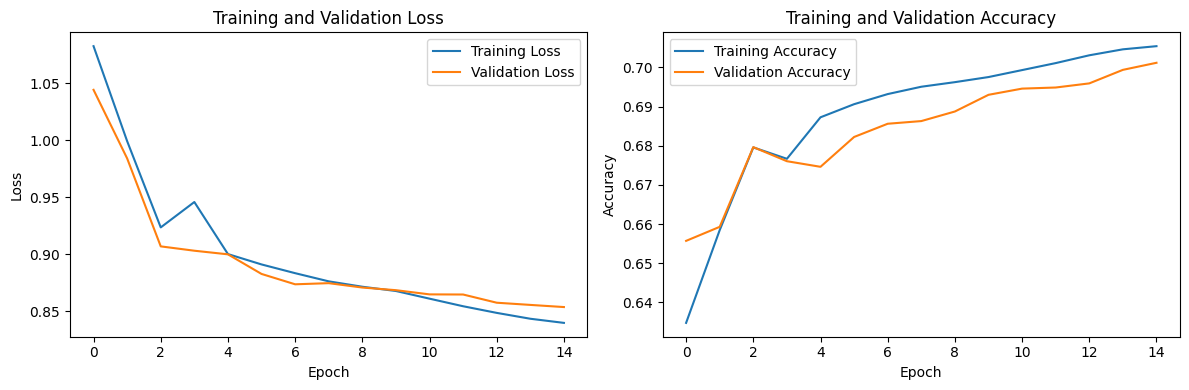

In [8]:
# Plot training history

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Section 9: Visualize

1/1 [==============================] - 0s 33ms/step


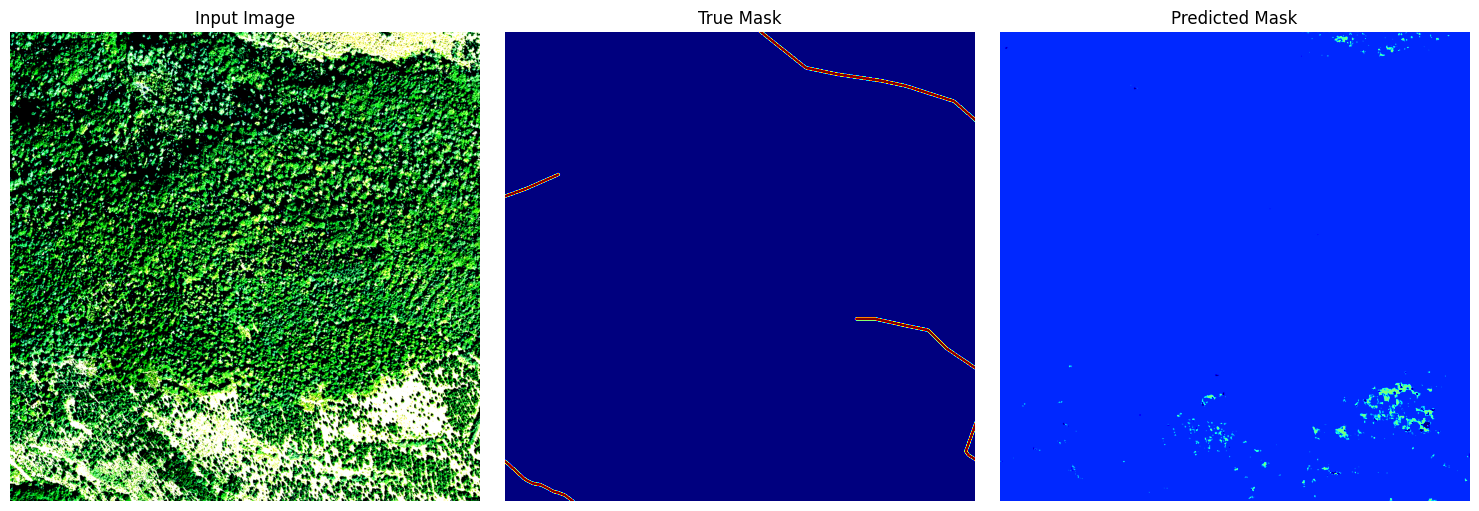

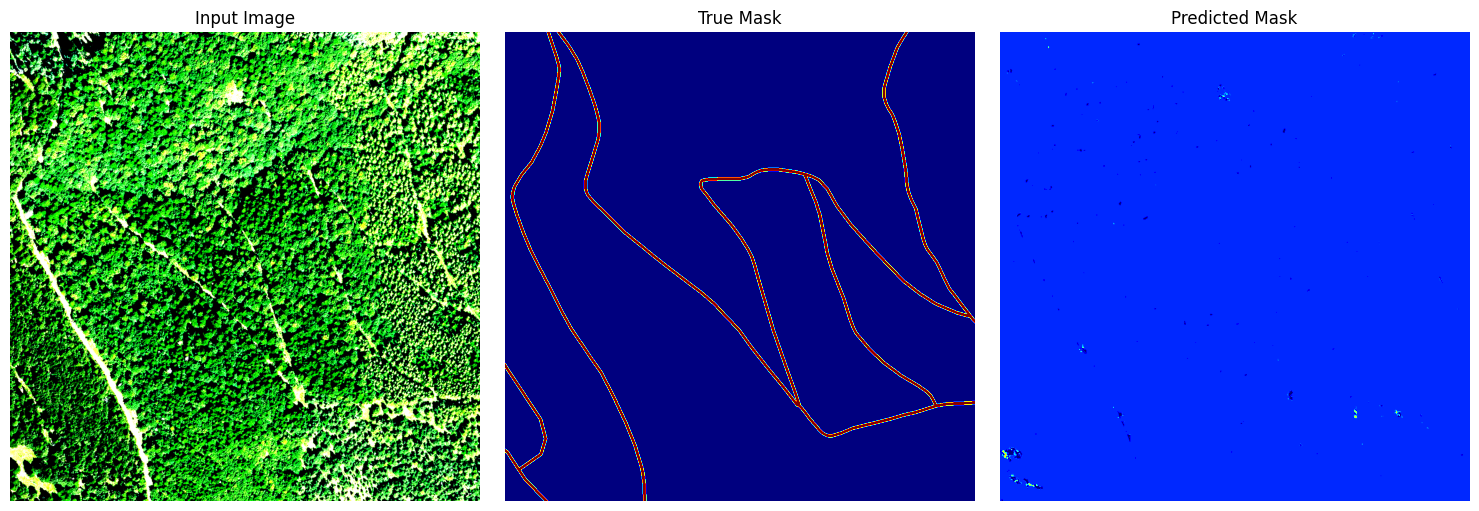

In [10]:
# Visualize predictions

def visualize_prediction(image, true_mask, pred_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(image)
    ax1.set_title('Input Image')
    ax1.axis('off')

    ax2.imshow(np.argmax(true_mask, axis=-1), cmap='jet')
    ax2.set_title('True Mask')
    ax2.axis('off')

    ax3.imshow(np.argmax(pred_mask, axis=-1), cmap='jet')
    ax3.set_title('Predicted Mask')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a few predictions
for batch_images, batch_masks in val_dataset.take(1):
    batch_pred = model.predict(batch_images)
    for i in range(BATCH_SIZE):
        visualize_prediction(batch_images[i], batch_masks[i], batch_pred[i])

Section 9: Save Model

In [11]:
model.save('imagesegmenting.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
